Tässä notebookissa käydään läpi miten Pythonilla käytetään Tilastokeskus PxWeb-tietokantoja JSON-rajapinnan kautta. 
Samalla tavalla voidaan käyttää mitä tahansa PxWeb-tekniikalla toteutettua tietokantaa, kunhan JSON-kysely saadaan 
muodostettua oikein. Tarvitset harjoituksessa kirjastoa pyjstat, joten asenna se Python ympäristöösi. 

Esimerkissä luodaan yhteys Tilastokeskuksen tietokantaan, joka sisältää kuluttajahintaindeksin vuositiedot 2014-2024 (2015 = 100). Tietokanta on saatavissa osoitteessa https://pxdata.stat.fi/PxWeb/pxweb/fi/StatFin/StatFin__khi/statfin_khi_pxt_11xc.px/.
Tarvittava JSON-kysely saadaan kopioimalla se suoraan Tilastokeskuksen sivulta sen jälkeen, kun halutut tiedot on valittu. 

In [1]:
import requests
import json

# Kopioi url Tilastokeskuksen sivulta.

url = "https://pxdata.stat.fi:443/PxWeb/api/v1/fi/StatFin/khi/statfin_khi_pxt_11xc.px"

# Kopioi kysely Tilastokeskuksen sivulta. 

query = {
    
  "query": [
    {
      "code": "Tiedot",
      "selection": {
        "filter": "item",
        "values": [
          "indeksipisteluku"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }

}

# Asetetaan headerit, jotta palvelin tietää vastaanottavansa JSON-dataa
headers = {"Content-Type": "application/json"}

# Lähetetään POST-pyyntö
response = requests.post(url, headers=headers, data=json.dumps(query))

# Tarkistetaan, että pyyntö onnistui. Kerrotaan käyttäjälle onnistuiko pyyntö vai ei. Tämä ei ole toiminnan kannalta pakollista, 
# mutta noudattaa hyvää ohjelmointitapaa ja antaa informaatiota koodin toimivuudesta. 
# Vastauskoodit ovat näkyvissä opiskeluohjeen linkistä. 

if response.status_code == 200:
    data = response.json()
    print("Vastaus saatiin onnistuneesti:")
    #Tulostetaan data, jotta nähdään mitä se sisältää (ei pakollista).
    print(data)
else:
    print("Pyyntö epäonnistui, statuskoodi:", response.status_code)
    print(response.text)

# Muunnetaan Dictionary-tyyppinen tieto Stringiksi, jotta voidaan käsitellä sitä Datareadillä. 
data = json.dumps(data)

Vastaus saatiin onnistuneesti:
{'version': '2.0', 'class': 'dataset', 'label': 'Kuluttajahintaindeksi (2015=100) muuttujina Vuosi ja Tiedot', 'source': 'Tilastokeskus, kuluttajahintaindeksi', 'updated': '2025-01-14T06:00:00Z', 'note': ["<A HREF='https://stat.fi/tilasto/dokumentaatio/khi' TARGET=_blank>Tilaston dokumentaatio</A>", '. tieto on puuttuva\r\n. tieto on puuttuva'], 'role': {'time': ['Vuosi'], 'metric': ['Tiedot']}, 'id': ['Vuosi', 'Tiedot'], 'size': [10, 1], 'dimension': {'Vuosi': {'label': 'Vuosi', 'category': {'index': {'2015': 0, '2016': 1, '2017': 2, '2018': 3, '2019': 4, '2020': 5, '2021': 6, '2022': 7, '2023': 8, '2024': 9}, 'label': {'2015': '2015', '2016': '2016', '2017': '2017', '2018': '2018', '2019': '2019', '2020': '2020', '2021': '2021', '2022': '2022', '2023': '2023', '2024': '2024'}}, 'extension': {'elimination': False, 'show': 'value'}}, 'Tiedot': {'label': 'Tiedot', 'category': {'index': {'indeksipisteluku': 0}, 'label': {'indeksipisteluku': 'Indeksipisteluk

In [3]:
# Kuten yltä huomataan, kysely palauttaa melkoisen "hässäkän". Kyselyn tuottama datan on JSONstat-muodossa. Pythonissa sitä käsitellään oletuksena
# sanakirjana (Dictionary). Jotta pyjstatin Datasetia voidaan käyttää, data muutetaan String-tyyppiseksi.

from pyjstat import pyjstat
#Luetaan data pyjstatin Datasetiin.
dataset = pyjstat.Dataset.read(data)

# Muunnetaan Dataset DataFrameksi
df = dataset.write('dataframe')

In [4]:
# Poistetaan DataFramesta kaikki muut sarakkeet paitsi Vuosi ja value.
df = df[['Vuosi','value']]

# Nimetään value uudelleen Pisteluvuksi.
df.rename(columns={'value': 'Pisteluku'}, inplace = True) #inplace = True sijoittaa muutoksen olemassa olevaan DataFrameen.

# Tulostetaan DataFramen sisältö.
df

,Vuosi,Pisteluku
0,2015,100.00
1,2016,100.35
2,2017,101.10
3,2018,102.20
4,2019,103.25
5,2020,103.55
6,2021,105.82
7,2022,113.36
8,2023,120.44
9,2024,122.33


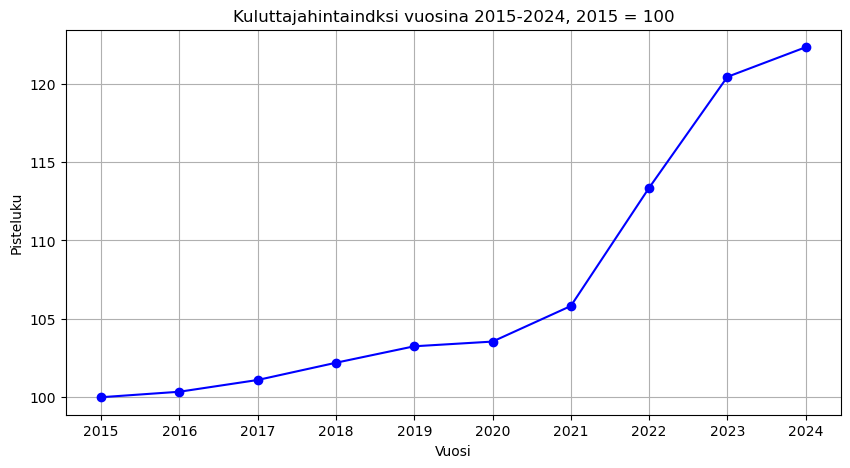

In [5]:
#Piirretään seuraavaksi kuluttajahintaindeksistä viivakaavio. 

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['Vuosi'], df['Pisteluku'], marker='o', linestyle='-', color='b')
plt.xlabel('Vuosi')
plt.ylabel('Pisteluku')
plt.title('Kuluttajahintaindksi vuosina 2015-2024, 2015 = 100')
plt.grid(True)
plt.show()